In [1]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm



train_path="data/train"


# read all folders in the train directory


labels=os.listdir(train_path)

def get_image_path_and_labels(path, labels):
    image_paths_and_labels = []
    for label in labels:
        image_paths = os.listdir(os.path.join(path,label))
        for image_path in image_paths:
            # if path ends with .jpg
            if image_path.endswith(".jpg"):
                image_paths_and_labels.append((os.path.join(path,label,image_path),label))
    return image_paths_and_labels

train_image_paths_and_labels = get_image_path_and_labels(train_path, labels)
print("Number of images in the training set: ",len(train_image_paths_and_labels))

validation_path="data/valid"
valid_image_paths_and_labels = get_image_path_and_labels(validation_path, labels)
print("Number of images in the validation set: ",len(valid_image_paths_and_labels))

test_path="data/test"
test_image_paths_and_labels = get_image_path_and_labels(test_path, labels)
print("Number of images in the test set: ",len(test_image_paths_and_labels))



Number of images in the training set:  13492
Number of images in the validation set:  500
Number of images in the test set:  500


In [2]:
class_to_idx = {c:i for i,c in enumerate(np.unique(labels))}
idx_to_class = {i:c for c,i in class_to_idx.items()}

num_classes= len(class_to_idx)

In [3]:
class_to_idx

{'air hockey': 0,
 'ampute football': 1,
 'archery': 2,
 'arm wrestling': 3,
 'axe throwing': 4,
 'balance beam': 5,
 'barell racing': 6,
 'baseball': 7,
 'basketball': 8,
 'baton twirling': 9,
 'bike polo': 10,
 'billiards': 11,
 'bmx': 12,
 'bobsled': 13,
 'bowling': 14,
 'boxing': 15,
 'bull riding': 16,
 'bungee jumping': 17,
 'canoe slamon': 18,
 'cheerleading': 19,
 'chuckwagon racing': 20,
 'cricket': 21,
 'croquet': 22,
 'curling': 23,
 'disc golf': 24,
 'fencing': 25,
 'field hockey': 26,
 'figure skating men': 27,
 'figure skating pairs': 28,
 'figure skating women': 29,
 'fly fishing': 30,
 'football': 31,
 'formula 1 racing': 32,
 'frisbee': 33,
 'gaga': 34,
 'giant slalom': 35,
 'golf': 36,
 'hammer throw': 37,
 'hang gliding': 38,
 'harness racing': 39,
 'high jump': 40,
 'hockey': 41,
 'horse jumping': 42,
 'horse racing': 43,
 'horseshoe pitching': 44,
 'hurdles': 45,
 'hydroplane racing': 46,
 'ice climbing': 47,
 'ice yachting': 48,
 'jai alai': 49,
 'javelin': 50,
 '

In [4]:

def read_single_image(image_path, label):
    img = Image.open(image_path)
    if img.mode != "RGB":
        img = img.convert("RGB")
    label = class_to_idx[label]
    label=torch.tensor(label, dtype=torch.long)
    return img, label


from joblib import Parallel, delayed

train_image_and_labels=Parallel(n_jobs=16)(delayed(read_single_image)(image_path, label) for image_path,label in tqdm(train_image_paths_and_labels))
valid_image_and_labels=Parallel(n_jobs=16)(delayed(read_single_image)(image_path, label) for image_path,label in tqdm(valid_image_paths_and_labels))
test_image_and_labels=Parallel(n_jobs=16)(delayed(read_single_image)(image_path, label) for image_path,label in tqdm(test_image_paths_and_labels))


  0%|          | 0/13492 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

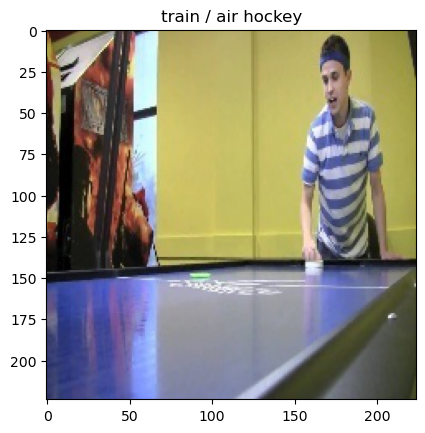

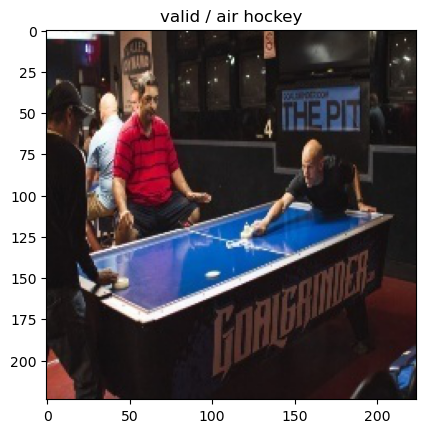

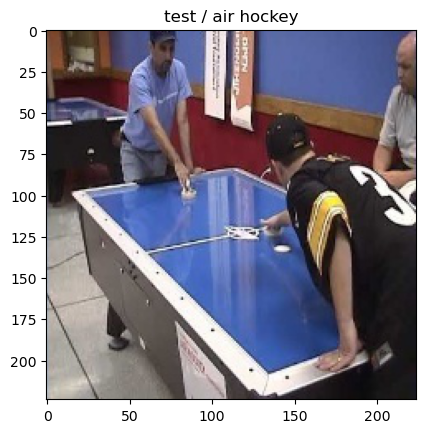

In [5]:
sample_img, sample_label = train_image_and_labels[0]
plt.imshow(sample_img)
plt.title("train / " +  idx_to_class[sample_label.item()])
plt.show()

sample_img, sample_label = valid_image_and_labels[0]
plt.imshow(sample_img)
plt.title("valid / " +  idx_to_class[sample_label.item()])
plt.show()

sample_img, sample_label = test_image_and_labels[0]
plt.imshow(sample_img)
plt.title("test / " +  idx_to_class[sample_label.item()])
plt.show()

In [15]:
import torchvision.transforms as transforms

many_transforms= transforms.Compose([
    # horizontal flip
    transforms.RandomHorizontalFlip(),
    # random rotation, mirror fill
    transforms.RandomRotation(5, expand=False, center=None, fill=None),
    # change brightness, saturation, hue
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.07),
    # random perspective
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5, interpolation=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # imagenet normalization
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


minimal_transforms= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # imagenet normalization
    # wir normalisieren die Werte auf den Bereich [0,1] und ziehen dann den Mittelwert ab und teilen durch die Standardabweichung
    # die Werte hier stammen aus dem ImageNet Datensatz, mit dem resnet trainiert wurde
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

current_transforms = many_transforms

In [16]:
class Dataset:
    def __init__(self, images_and_labels, transforms=None):
        self.images_and_labels = images_and_labels
        self.size = len(images_and_labels)
        self.transforms=transforms
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        try:
            x,y=self.images_and_labels[idx]
            if self.transforms:
                x = self.transforms(x)
        except:
            print(f'Error at index {idx}, len of dataset is {self.size}') 
            raise
        return x, y

train_dataset = Dataset(train_image_and_labels, transforms=current_transforms)
x, y = train_dataset[6000]
print(x.shape)

torch.Size([3, 224, 224])


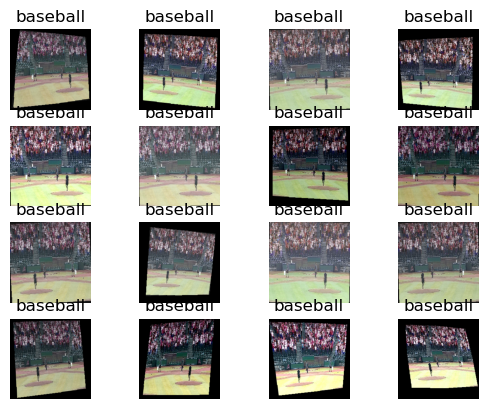

In [17]:
fig, ax= plt.subplots(4, 4)

for i in range(16):
    x,y=train_dataset[999]
    #revert imagenet normalization
    mean=torch.tensor([0.485, 0.456, 0.406])
    std=torch.tensor([0.229, 0.224, 0.225])
    x=x*std[:, None, None]+mean[:, None, None]
    ax[i//4, i%4].imshow(x.permute(1,2,0))
    ax[i//4, i%4].set_title(idx_to_class[y.item()])
    ax[i//4, i%4].axis('off')
plt.show()

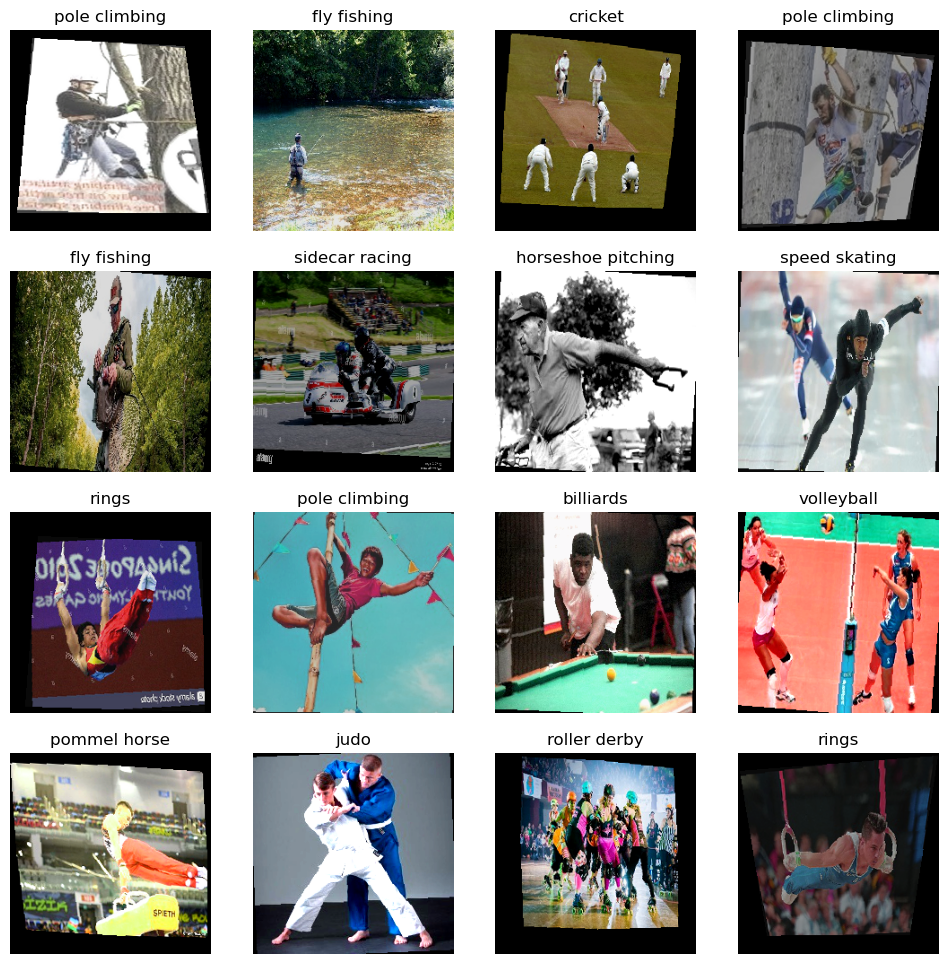

In [18]:
sample_loader= torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

fig, ax= plt.subplots(4,4, figsize=(12,12))
for x,y in sample_loader:
    for i in range(16):
        xi=x[i]
        mean=torch.tensor([0.485, 0.456, 0.406])
        std=torch.tensor([0.229, 0.224, 0.225])
        xi=xi*std[:, None, None]+mean[:, None, None]
        xi=xi.permute(1,2,0)
        ax[i//4, i%4].imshow(xi)
        ax[i//4, i%4].set_title(idx_to_class[y[i].item()])
        #remove axis
        ax[i//4, i%4].axis('off')
    break

In [19]:
import torchvision
from torchvision.models import ResNet18_Weights

class SportsModel(torch.nn.Module):
    def __init__(self, hidden_size=None, dropout=0.4):
        super().__init__()
        self.backbone=torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.backbone.fc=torch.nn.Sequential(
            torch.nn.Linear(512, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.BatchNorm1d(hidden_size),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.BatchNorm1d(hidden_size),
            torch.nn.Linear(hidden_size, num_classes)
        )
        self.freeze()

    def freeze(self):
        for param in self.backbone.parameters():
            param.requires_grad=False
        for param in self.backbone.fc.parameters():
            param.requires_grad=True

    def unfreeze(self):
        for param in self.backbone.parameters():
            param.requires_grad=True
 
    def forward(self, x):
        x=self.backbone(x)
        return x
    
# wir bauen das Modell
model=SportsModel(hidden_size=1000)
# wir bauen das Dataset
dataset_sample=Dataset(train_image_and_labels, transforms=current_transforms)
# wir bauen den DataLoader
loader=torch.utils.data.DataLoader(dataset_sample, batch_size=13, shuffle=True)
# ein einziges Batch-Beispiel wird aus dem Dataloader geladen
for xb, yb in loader:
    print(model(xb).shape)
    assert model(xb).shape==torch.Size([13, num_classes]), "Error: model(xb).shape!=torch.Size([13, 10])"
    break



torch.Size([13, 100])


In [20]:


# hier will ich mehr Varianz in den Trainingsbildern (also quasi mehr Bilder als ich eigentlich habe)
train_dataset=Dataset(train_image_and_labels, transforms=current_transforms)

# ich will bei ECHTEN Bildern gut sein, also keine Veränderungen der Bilder
valid_dataset=Dataset(valid_image_and_labels, transforms=minimal_transforms)
test_dataset=Dataset(test_image_and_labels, transforms=minimal_transforms)

In [21]:
print(len(train_dataset), len(valid_dataset), len(test_dataset))

13492 500 500


In [22]:
def get_accuracy(model, loader, device):
    model.eval()
    correct=0
    total=0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)   
            y_pred=model(xb)
            y_pred=torch.argmax(y_pred, dim=1)
            correct+=(y_pred==yb).sum().item()
            total+=len(yb)
    return correct/total

106
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/bernd.heidemann/fa22boxfordpets/e/FAB-95


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Unfreezing model


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

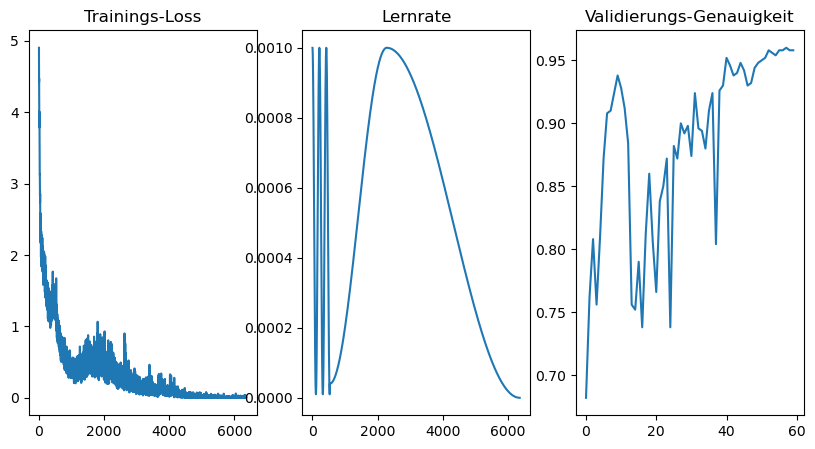

In [23]:
import neptune

torch.manual_seed(0)

lr=0.001
batch_size=128  # 64 im run
epochs=60       # 60 im run
unfreeze_epoch=5
hidden_size=1000

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

#device=torch.device('cpu')

train_loader=torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
valid_loader=torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
test_loader=torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
eval_steps=len(train_loader)
print(eval_steps)
model=SportsModel(hidden_size).to(device)
#weight_decay: Hohe Gewichte werden bestraft, um Overfitting zu vermeiden
optimizer=torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0001)
#RMSprop: Optimierungsalgorithmus
#optimizer=torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=0.0001)
# OneCycleLR: Lernrate wird während des Trainings erhöht und dann wieder verringert
scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader), eta_min=0.00001)

# CrossEntropyLoss: Klassifikationsproblem mit mehreren Klassen
loss_func=torch.nn.CrossEntropyLoss()


run = neptune.init_run(
    project="bernd.heidemann/fa22boxfordpets",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzNjBlYzVkNi0zZTUwLTQ1ODYtODhlNC02NDUxNDg0MDdjNzUifQ==",
)  # your credentials

losses=[]
valid_losses=[]
learning_rates=[]
accs=[]

best_acc=0
postfix={}
for i in range(epochs):
    if i==unfreeze_epoch:
        model.unfreeze()
        learnrates=[lr/10, lr/5, lr]
        optimizer=torch.optim.AdamW([
            {'params': model.backbone.conv1.parameters(), 'lr': learnrates[0]},
            {'params': model.backbone.layer1.parameters(), 'lr': learnrates[0]},
            {'params': model.backbone.layer2.parameters(), 'lr': learnrates[0]},
            {'params': model.backbone.layer3.parameters(), 'lr': learnrates[1]},
            {'params': model.backbone.layer4.parameters(), 'lr': learnrates[1]},
            {'params': model.backbone.fc.parameters(), 'lr': learnrates[2]}
        ], weight_decay=0.0001)
        #optimizer=torch.optim.RMSprop(model.parameters(), lr=lr/10, weight_decay=0.0001)
        scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,  epochs=epochs-unfreeze_epoch, steps_per_epoch=len(train_loader))
        print('Unfreezing model')
    model.train()
    bar= tqdm(train_loader, total=len(train_loader), leave=False)  
    bar.set_description(f"Epoch {i+1}/{epochs}")
    steps=0
    bar.set_postfix(postfix)
    for xb, yb in bar:
        steps+=1
        bar.update(1)
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()                   # Gradienten (Ableitungen) zurücksetzen
        pred=model(xb)                          # Forward-Propagation
        loss=loss_func(pred, yb)                # Loss berechnen
        loss.backward()                         # ableiten
        optimizer.step()                        # Gewichte aktualisieren
        losses.append(loss.item())              # Loss speichern
        run["train/loss"].log(loss.item())
        scheduler.step()                        # Lernrate aktualisieren
        learning_rates.append(scheduler.get_last_lr()[0])
        run["train/lr"].log(scheduler.get_last_lr()[0])

        if steps%eval_steps==0:
            valid_acc=get_accuracy(model, valid_loader, device)
            test_acc=get_accuracy(model, test_loader, device)
            accs.append(valid_acc)
            if valid_acc>best_acc:
                best_acc=valid_acc
                torch.save(model.state_dict(), 'best_model.pth')
           
            postfix={
                    'loss': sum(losses[-eval_steps:])/eval_steps,
                    'lr': scheduler.get_last_lr()[0], 
                    'val_accuracy': valid_acc
                 }
            bar.set_postfix(postfix)
            run["val/accuracy"].log(valid_acc)
            run["test/accuracy"].log(test_acc)
            run["val/loss"].log(sum(losses[-eval_steps:])/eval_steps)
            
fig, ax=plt.subplots(1,3, figsize=(10,5))
ax[0].plot(losses)
ax[0].set_title('Trainings-Loss')
ax[1].plot(learning_rates)
ax[1].set_title('Lernrate')
ax[2].plot(accs)
ax[2].set_title('Validierungs-Genauigkeit')

plt.show()

In [24]:
get_accuracy(model, valid_loader, device)

0.958

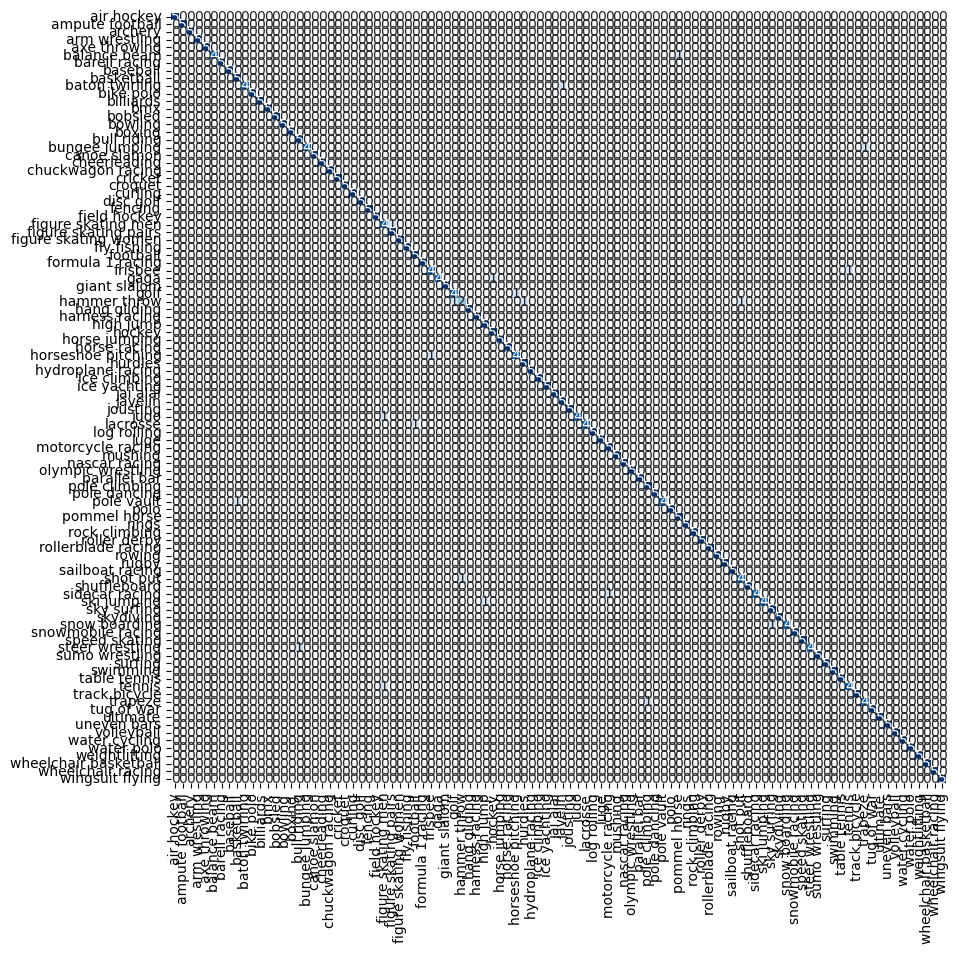

In [25]:
# get confusion matrix for validation dataset

from sklearn.metrics import confusion_matrix
import seaborn as sns

def get_confusion_matrix(model, loader):
    model.eval()
    y_true=[]
    y_pred=[]
    
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            y_pred.append(torch.argmax(model(xb), dim=1).cpu())
            y_true.append(yb.cpu())
    y_true=torch.cat(y_true)
    y_pred=torch.cat(y_pred)
    return confusion_matrix(y_true, y_pred)

confusion_matrix=get_confusion_matrix(model, valid_loader)
plt.figure(figsize=(10,10))

class_names=[idx_to_class[i] for i in range(num_classes)]
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.show()


In [26]:
# show top 3 confusion pairs
import numpy as np
confusion_matrix=np.array(confusion_matrix)
np.fill_diagonal(confusion_matrix, 0)
top3=np.argsort(confusion_matrix, axis=None)[-10:]
top3=np.unravel_index(top3, confusion_matrix.shape)
for i in range(10):
    print(f'{class_names[top3[0][i]]} vs {class_names[top3[1][i]]}: {confusion_matrix[top3[0][i], top3[1][i]]} samples')

steer wrestling vs bull riding: 1 samples
golf vs horseshoe pitching: 1 samples
figure skating men vs figure skating pairs: 1 samples
horseshoe pitching vs frisbee: 1 samples
balance beam vs pommel horse: 1 samples
pole vault vs basketball: 1 samples
ski jumping vs high jump: 1 samples
sidecar racing vs motorcycle racing: 1 samples
hammer throw vs shot put: 1 samples
trapeze vs pole climbing: 1 samples


In [ ]:
# https://app.neptune.ai/bernd.heidemann/fa22boxfordpets/e/FAB-95